In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ca_cardiac_model
import optimap as om
import math
import random


In [3]:
print(ca_cardiac_model.cardiac_simulation.__doc__)  # Assuming 'test' is your subroutine name


v_out,cb_out,csrb_out,ci_out,t_out,num_steps = cardiac_simulation(lx,ly,nstim,iseed,rbcl,dfu,gicai,gtos,gtof,gnacai,zxr,nbt,cxinit,xnai,xnao,xki,xko,cao,temp,xxr,xf,dt,max_buffer_size,mod_output,parallel_exec,stimulus_function,[stimulus_function_extra_args])

Wrapper for ``cardiac_simulation``.

Parameters
----------
lx : input int
ly : input int
nstim : input int
iseed : input int
rbcl : input float
dfu : input float
gicai : input float
gtos : input float
gtof : input float
gnacai : input float
zxr : input float
nbt : input int
cxinit : input float
xnai : input float
xnao : input float
xki : input float
xko : input float
cao : input float
temp : input float
xxr : input float
xf : input float
dt : input float
max_buffer_size : input int
mod_output : input int
parallel_exec : input int
stimulus_function : call-back function

Other Parameters
----------------
stimulus_function_extra_args : input tuple, optional
    Default: ()

Returns
-------
v_out : rank-3 array('d') with bounds (max_b

In [4]:
# Set parameters from the provided defaults
lx = 100  # Assuming a small grid size, adjust as needed
ly = 100  # Assuming a small grid size, adjust as needed
nstim = 2  # Number of stimuli, adjust as needed
iseed = 823323  # Initial random number seed
rbcl = 1000.0  # Pacing rate
dfu = 0.0001  # Effective voltage diffusion coefficient

# Ionic current parameters
gicai = 2.20  # Strength of LCC
gtos = 0.04  # Strength of ito slow
gtof = 0.15  # Strength of ito fast
gnacai = 1.5  # Strength of NCX

zxr = 0.09  # Controls degree of Ca-induced inactivation

nbt = 4000  # Total number of RyR2 clusters
cxinit = 1200.0  # Initial SR load

# Sodium concentration calculation
xmx = -2.0/250.0
xnai = xmx * 520.0 + 16.0  # Constant Na concentration

# Constants
xnao = 136.0  # External Na (mM)
xki = 140.0  # Internal K (mM)
xko = 5.40  # External K (mM)
cao = 1.8  # External Ca (mM)

temp = 308.0  # Temperature (K)
xxr = 8.314  # Gas constant
xf = 96.485  # Faraday's constant

dt = .5  # Time step
parallel = False # RK4

mod_output = 10 

nstep = rbcl/dt 

max_buffer_size = math.ceil((nstep*nstim) /mod_output) + (nstim)


def stimulus_function(ix, iy, time):
    # Example: Stimulate a 10x10 corner for the first 1ms
    if time < 1.0 and ix < 5 and iy < 5:
        return 80.0
    else:
        return 0.0


In [5]:

def random_stimulus_function(ix, iy, time, new_stimulus_probability=0.001):
    #print(ix,iy,time)
    if(True):
        if(random.random()<new_stimulus_probability):
            return 120
        else:
            return 0
    else:
        return 0


current_time = 0
points = np.meshgrid(range(1,ly),range(1,lx))
launch = False

In [6]:
# Global variables to maintain state between calls
last_time_checked = -1
stimulus_centers = []
stimulus_active = False
stimulus_start_time = 0

def localized_random_stimulus(ix, iy, time, radius=5, stim_duration=1.0, time_prob=0.01):
    global last_time_checked, stimulus_centers, stimulus_active, stimulus_start_time
    
    # Check if we're at a new time point
    if abs(time - last_time_checked) > 1e-6:  # Floating point comparison
        last_time_checked = time
        
        # If stimulus is active, check if it should end
        if stimulus_active and (time - stimulus_start_time > stim_duration):
            stimulus_active = False
        
        # Randomly decide to start a new stimulus
        if not stimulus_active and random.random() < time_prob:
            stimulus_active = True
            stimulus_start_time = time
            # Choose a random center point
            center_x = random.randint(1, lx)
            center_y = random.randint(1, ly)
            stimulus_centers = [(center_x, center_y)]
    
    # Check if current point is within the stimulus radius of any center
    
    if stimulus_active:
        #print(stimulus_active)
        for center_x, center_y in stimulus_centers:
            distance = ((ix - center_x)**2 + (iy - center_y)**2)**0.5
            if distance <= radius:
                return 80.0  # Return stimulus current
    
    return 0.0  # No stimulus

In [7]:
v_out, cb_out, csrb_out, ci_out, t_out, num_steps = ca_cardiac_model.cardiac_simulation(
        lx, ly, nstim, iseed, rbcl, dfu, gicai, gtos, gtof, gnacai, zxr, nbt, 
        cxinit, xnai, xnao, xki, xko, cao, temp, xxr, xf, dt,
        max_buffer_size,mod_output,parallel,localized_random_stimulus
    )

## Look at output shapes

In [8]:
v_out.shape

(402, 100, 100)

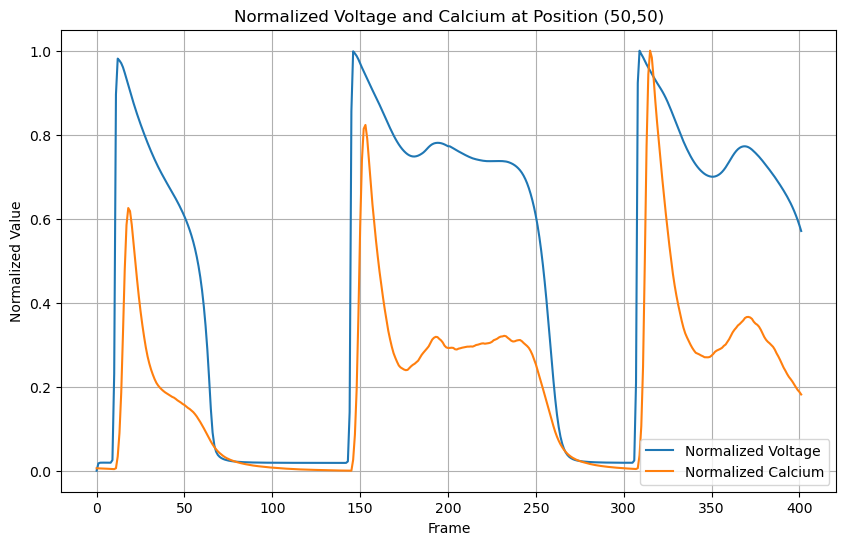

In [15]:
#plt.xlim([0,510])
v_series = v_out[:, 50, 50]
cb_series = cb_out[:, 50, 50]

# Normalize the time series
def normalize(series):
    return (series - np.min(series)) / (np.max(series) - np.min(series))

v_series_normalized = normalize(v_series)
cb_series_normalized = normalize(cb_series)

# Plot the normalized time series
plt.figure(figsize=(10, 6))
plt.plot(v_series_normalized, label='Normalized Voltage')
plt.plot(cb_series_normalized, label='Normalized Calcium')
plt.xlabel('Frame')
plt.ylabel('Normalized Value')
plt.title('Normalized Voltage and Calcium at Position (50,50)')
plt.legend()
plt.grid(True)
plt.show()

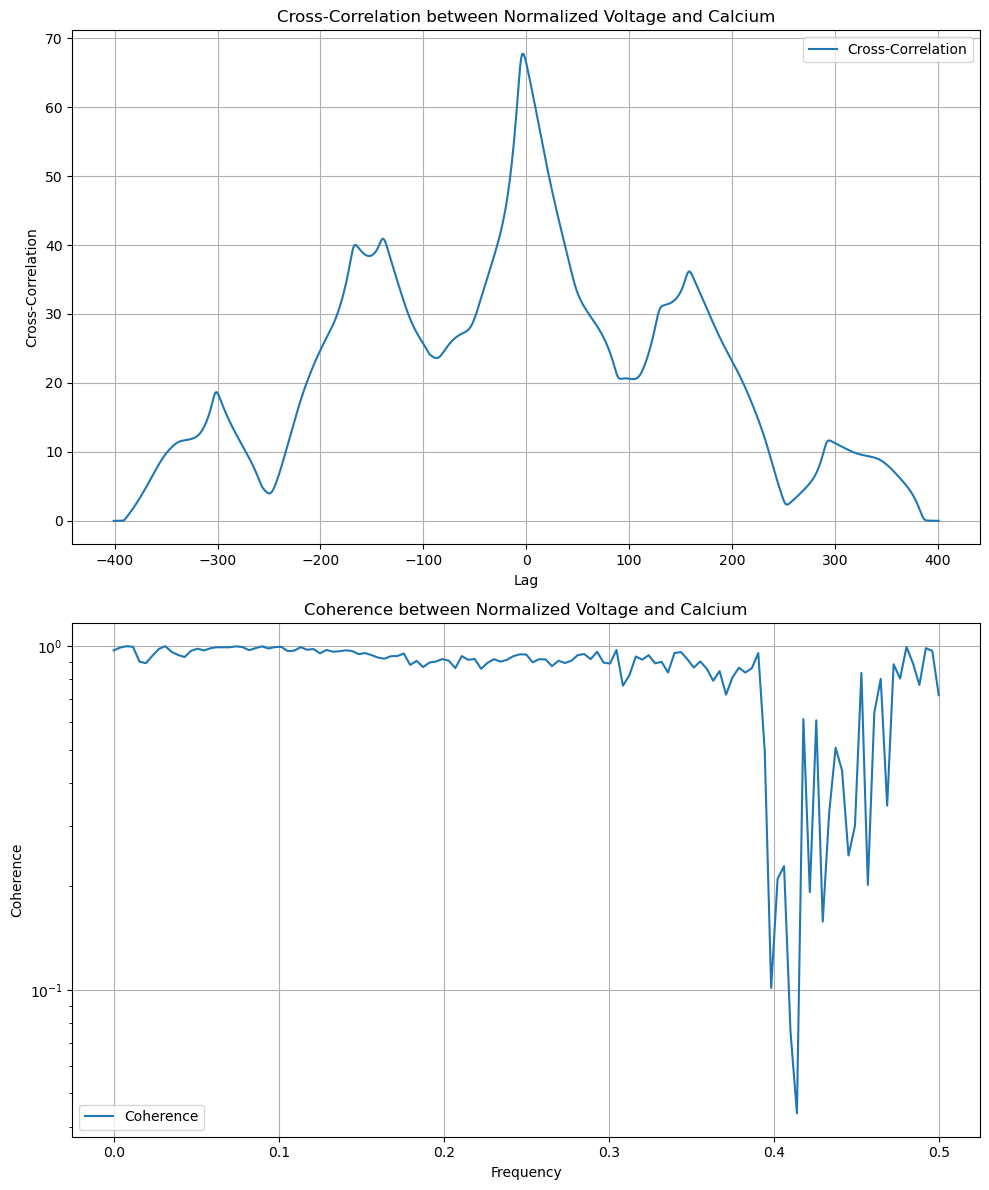

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, coherence

# Define the normalization function
def normalize(series):
    return (series - np.min(series)) / (np.max(series) - np.min(series))

# Assuming v_out and cb_out are already defined
# Extract the time series for the spatial point (50,50)
v_series = v_out[:, 50, 50]
cb_series = cb_out[:, 50, 50]

# Normalize the time series
v_series_normalized = normalize(v_series)
cb_series_normalized = normalize(cb_series)

# Calculate cross-correlation
cross_corr = correlate(v_series_normalized, cb_series_normalized, mode='full')
lags = np.arange(-len(v_series_normalized) + 1, len(v_series_normalized))

# Calculate coherence
frequencies, Cxy = coherence(v_series_normalized, cb_series_normalized)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot cross-correlation
ax1.plot(lags, cross_corr, label='Cross-Correlation')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Cross-Correlation')
ax1.set_title('Cross-Correlation between Normalized Voltage and Calcium')
ax1.legend()
ax1.grid(True)

# Plot coherence
ax2.semilogy(frequencies, Cxy, label='Coherence')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Coherence')
ax2.set_title('Coherence between Normalized Voltage and Calcium')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [17]:
#video_voltage = om.load_video(v_out)
video_voltage = om.video.normalize_pixelwise((v_out))
video_csrb = om.video.normalize_pixelwise((cb_out))
video_cb = om.video.normalize_pixelwise((csrb_out))
video_ci = om.video.normalize_pixelwise((ci_out))

voltage_phase = om.phase.compute_phase(v_out)


'''
video_voltage = om.video.normalize_pixelwise(v_out)
video_csrb = om.video.normalize_pixelwise(cb_out)
video_cb = om.video.normalize_pixelwise(csrb_out)
video_ci = om.video.normalize_pixelwise(ci_out)
'''

'\nvideo_voltage = om.video.normalize_pixelwise(v_out)\nvideo_csrb = om.video.normalize_pixelwise(cb_out)\nvideo_cb = om.video.normalize_pixelwise(csrb_out)\nvideo_ci = om.video.normalize_pixelwise(ci_out)\n'

In [18]:
om.show_videos([v_out,video_voltage, video_csrb, video_cb,video_ci], titles=["V-phase","Voltage", "Csrb", "Cb","Ci"],vmins=[v_out.min(),0,0,0,0],vmaxs=[v_out.max(),1,1,1,1]);

In [19]:
om.export_videos(
    "voltage_ca_spiral_300_300.mp4",
    [video_voltage, video_csrb, video_cb,video_ci],
    fps=120,
    ncols=2,
    vmins=0,
    vmaxs=1
)

exporting video: 100%|██████████| 402/402 [00:00<00:00, 421.96it/s]


Video exported to voltage_ca_spiral_300_300.mp4


In [20]:
om.show_video(voltage_phase, title='removed outliers', cmap='hsv');

Global time delay: -3 frames


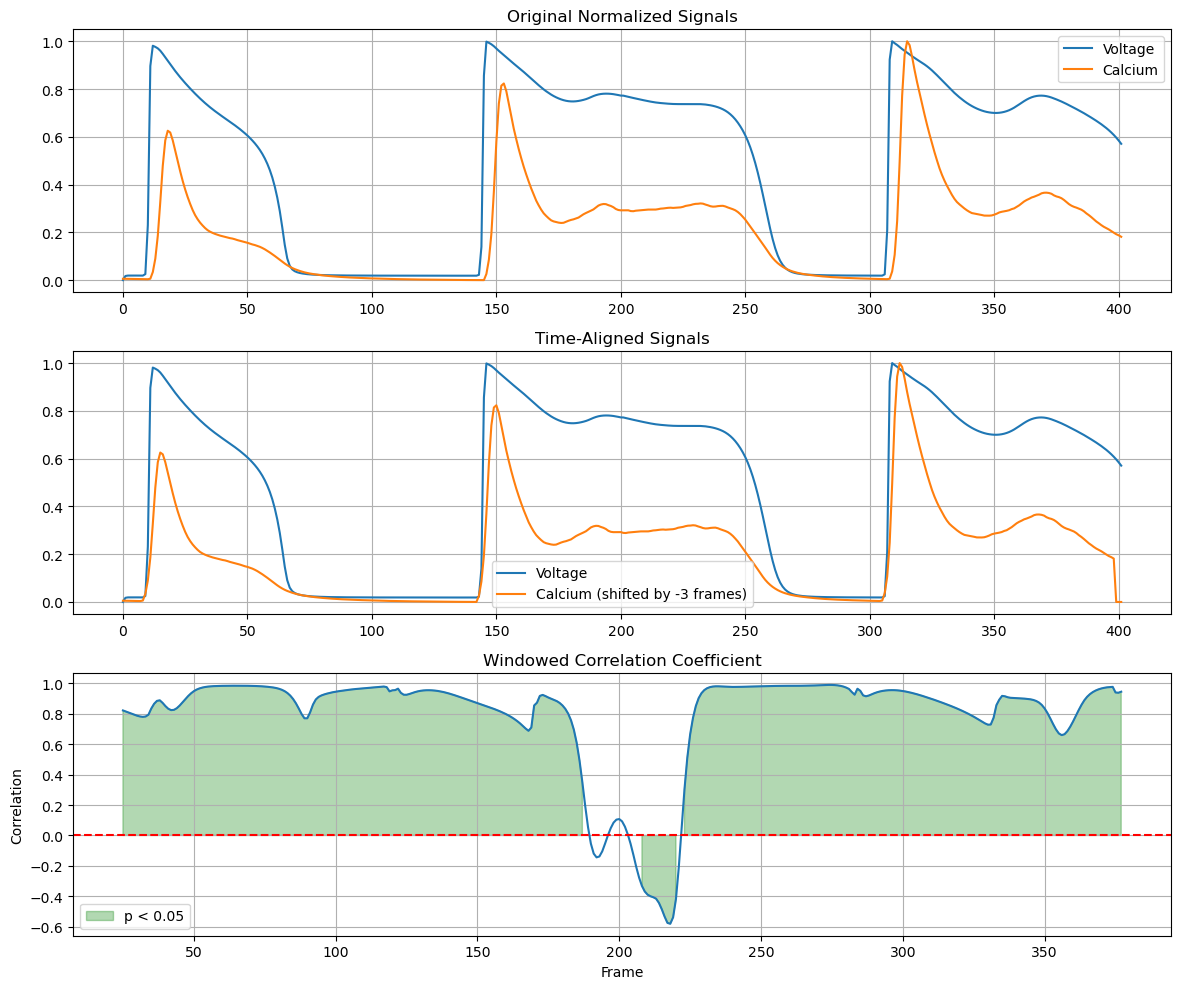

Potential dissociation points at frames: [187 222]


In [21]:
from scipy.signal import correlate
from scipy.stats import pearsonr

# Define the normalization function
def normalize(series):
    return (series - np.min(series)) / (np.max(series) - np.min(series))


v_series = v_out[:, 50, 50]
cb_series = cb_out[:, 50, 50]
v_series_normalized = normalize(v_series)
cb_series_normalized = normalize(cb_series)

# Calculate global cross-correlation
cross_corr = correlate(v_series_normalized, cb_series_normalized, mode='full')
lags = np.arange(-len(v_series_normalized) + 1, len(v_series_normalized))

# Find the lag with the maximum cross-correlation
max_corr_idx = np.argmax(cross_corr)
global_time_delay = lags[max_corr_idx]
print(f"Global time delay: {global_time_delay} frames")

# Shift calcium signal by the global time delay
if global_time_delay > 0:
    # Calcium follows voltage with delay
    cb_shifted = np.pad(cb_series_normalized[:-global_time_delay], (global_time_delay, 0), 'constant')
elif global_time_delay < 0:
    # Voltage follows calcium (unlikely in your case)
    cb_shifted = np.pad(cb_series_normalized[-global_time_delay:], (0, -global_time_delay), 'constant')
else:
    cb_shifted = cb_series_normalized

# Perform windowed correlation analysis
window_size = 50  # Adjust based on your data
step_size = 1
n_windows = len(v_series_normalized) - window_size + 1
window_correlations = []
p_values = []
time_points = []

# Fixed the window correlation calculation to ensure arrays have matching lengths
for i in range(0, n_windows, step_size):
    v_window = v_series_normalized[i:i+window_size]
    cb_window = cb_shifted[i:i+window_size]
    corr, p_val = pearsonr(v_window, cb_window)
    window_correlations.append(corr)
    p_values.append(p_val)
    time_points.append(i + window_size//2)  # Center of the window

# Convert lists to numpy arrays
window_correlations = np.array(window_correlations)
p_values = np.array(p_values)
time_points = np.array(time_points)

# Plot the results
plt.figure(figsize=(12, 10))

# Plot 1: Original signals
plt.subplot(3, 1, 1)
plt.plot(v_series_normalized, label='Voltage')
plt.plot(cb_series_normalized, label='Calcium')
plt.title('Original Normalized Signals')
plt.legend()
plt.grid(True)

# Plot 2: Shifted signals
plt.subplot(3, 1, 2)
plt.plot(v_series_normalized, label='Voltage')
plt.plot(cb_shifted, label=f'Calcium (shifted by {global_time_delay} frames)')
plt.title('Time-Aligned Signals')
plt.legend()
plt.grid(True)

# Plot 3: Windowed correlation
plt.subplot(3, 1, 3)
plt.plot(time_points, window_correlations)
plt.axhline(y=0, color='r', linestyle='--')
plt.fill_between(time_points, 
                 window_correlations, 
                 0, 
                 where=(p_values < 0.05),
                 color='green', alpha=0.3, 
                 label='p < 0.05')

plt.title('Windowed Correlation Coefficient')
plt.xlabel('Frame')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Find points where correlation drops significantly
threshold = 0.3  # Adjust based on your data
dissociation_points = np.where(np.diff(window_correlations < threshold))[0]
if len(dissociation_points) > 0:
    print("Potential dissociation points at frames:", dissociation_points + window_size//2)
else:
    print("No clear dissociation points detected with current threshold.")


In [41]:
import numpy as np
from scipy.signal import correlate
#import numba as nb
from tqdm import tqdm

#@nb.njit(parallel=True)
def normalize(series):
    min_val = np.min(series)
    max_val = np.max(series)
    return (series - min_val) / (max_val - min_val)

#@nb.njit
def fast_corrcoef(x, y):
    """Fast correlation coefficient calculation without p-value"""
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    numerator = np.sum(x_centered * y_centered)
    denominator = np.sqrt(np.sum(x_centered**2) * np.sum(y_centered**2))
    
    if denominator == 0:
        return 0.0
    return numerator / denominator

#@nb.njit
def process_pixel(v_series, cb_series, window_size=20, step_size=1):
    v_series_normalized = normalize(v_series)
    cb_series_normalized = normalize(cb_series)
    
    # Calculate global cross-correlation (can't use scipy.signal.correlate with Numba)
    n = len(v_series_normalized)
    max_corr = -2.0  # Correlation is between -1 and 1
    global_time_delay = 0
    
    # Only check reasonable lags (e.g., ±20% of signal length)
    max_lag = min(n // 5, 50)  # Adjust as needed for your data
    
    for lag in range(-max_lag, max_lag + 1):
        if lag > 0:
            corr = fast_corrcoef(v_series_normalized[lag:], cb_series_normalized[:-lag])
        elif lag < 0:
            corr = fast_corrcoef(v_series_normalized[:lag], cb_series_normalized[-lag:])
        else:
            corr = fast_corrcoef(v_series_normalized, cb_series_normalized)
            
        if corr > max_corr:
            max_corr = corr
            global_time_delay = lag
    
    # Shift calcium signal
    if global_time_delay > 0:
        cb_shifted = np.zeros_like(cb_series_normalized)
        cb_shifted[global_time_delay:] = cb_series_normalized[:-global_time_delay]
    elif global_time_delay < 0:
        cb_shifted = np.zeros_like(cb_series_normalized)
        cb_shifted[:global_time_delay] = cb_series_normalized[-global_time_delay:]
    else:
        cb_shifted = cb_series_normalized
    
    # Windowed correlation analysis
    n_windows = len(v_series_normalized) - window_size + 1
    window_correlations = np.zeros(n_windows // step_size)
    
    for i in range(0, n_windows, step_size):
        idx = i // step_size
        v_window = v_series_normalized[i:i+window_size]
        cb_window = cb_shifted[i:i+window_size]
        window_correlations[idx] = fast_corrcoef(v_window, cb_window)
    
    return global_time_delay, window_correlations

#@nb.njit(parallel=True)
def process_row(row_idx, v_out, cb_out, window_size, step_size, global_delays, windowed_correlations):
    """Process a single row of the matrices in parallel"""
    width = v_out.shape[1]
    for j in range(width):
        global_delays[row_idx, j], windowed_correlations[row_idx, j] = process_pixel(
            v_out[row_idx, j], cb_out[row_idx, j], window_size, step_size
        )

def process_matrices(v_out, cb_out, window_size=20, step_size=1):
    """Process entire matrices with parallel row processing"""
    assert v_out.shape == cb_out.shape, "Input matrices must have the same shape"
    
    # Reshape if necessary to ensure we have a 3D matrix (height x width x time)
    if v_out.ndim == 2:
        v_out = v_out.reshape(v_out.shape[0], 1, v_out.shape[1])
        cb_out = cb_out.reshape(cb_out.shape[0], 1, cb_out.shape[1])
        
    height, width, time_points = v_out.shape
    n_windows = time_points - window_size + 1
    n_output_points = (n_windows + step_size - 1) // step_size  # Ceiling division
    
    global_delays = np.zeros((height, width), dtype=np.int32)
    windowed_correlations = np.zeros((height, width, n_output_points))
    
    # Process each row in parallel
    for i in tqdm(range(height)):
        process_row(i, v_out, cb_out, window_size, step_size, global_delays, windowed_correlations)
    
    return global_delays, windowed_correlations




In [42]:
global_delays, windowed_correlations = process_matrices(v_out, cb_out)

  0%|                                                                                                                                                                                                                      | 0/402 [00:00<?, ?it/s]/tmp/ipykernel_1309403/4259065676.py:10: RuntimeWarning: invalid value encountered in divide
  return (series - min_val) / (max_val - min_val)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 402/402 [00:50<00:00,  7.92it/s]
